# Decoding Director Success: Predictive Analytics for Board Performance

### Import the library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import keras_tuner
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tabulate import tabulate
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [2]:
file_name = '/Users/tj/Downloads/BS_AllCompanies_Overview_March2023update.xlsx'
direct_comp = pd.read_excel(file_name, sheet_name= 'DIRECTOR_COMPANY_COREMETRICS')
direct = pd.read_excel(file_name, sheet_name= 'DIRECTOR_COREMETRICS')
company = pd.read_excel(file_name, sheet_name= 'COMPANY_COREMETRICS')

### Merge director and director_company datasets

In [3]:
comp = company[['COMPANY: TICKER',
       'WHO: AVERAGE AGE', 'WHO: % WOMEN',
       'WHO: % INSIDERS', 'WHO: % CEOS', 'WHO: % SMART PEOPLE',
       'WHO: % CONNECTED TO EACH OTHER', 'WHO: NETWORK POWER',
       'INFLUENCERS: BOARD TYPE', 'INFLUENCERS: HIGHEST INFLUENCE %',
       'INFLUENCE: AGE', 'INFLUENCE: FEMALE', 'INFLUENCE: GENDER POWER GAP',
       'INFLUENCE: INSIDERS', 'INFLUENCE: CEOS / EX CEOS',
       'INFLUENCE: SMARTIES', 'INFLUENCE: CONNECTED DIRECTORS',
       'INFLUENCE: PAY COMMITTEE', 'INFLUENCE: NOMINATING COMMITTEE',
       'INFLUENCE: AUDIT COMMITTEE']]
comp = comp.dropna()

In [4]:
direct = direct[['DIRECTOR: ID','RESUME: SMARTS', 'RESUME: EXPERIENCE',
       'RESUME: AVERAGE BOARD CONNECTS', 'RESUME: NETWORK POWER','INFLUENCE: 5YR MEDIAN','PERFORMANCE: CATEGORY','INFLUENCE: HIGHEST INFLUENCE AT…']]

In [5]:
df = pd.merge(direct_comp, direct, left_on = ['DIRECTOR: ID','COMPANY: NAME'], right_on = ['DIRECTOR: ID','INFLUENCE: HIGHEST INFLUENCE AT…'])

In [6]:
df = pd.merge(df, comp, on = 'COMPANY: TICKER')

## Exploratory Data Analysis

In [7]:
data = pd.merge(direct_comp, direct, left_on = ['DIRECTOR: ID','COMPANY: NAME'], right_on = ['DIRECTOR: ID','INFLUENCE: HIGHEST INFLUENCE AT…'])

In [8]:
data = pd.merge(data, comp, on = 'COMPANY: TICKER')

In [9]:
data[['DIRECTOR: GENDER','DIRECTOR: AGE','RESUME: EXPERIENCE','INFLUENCE: CEOS / EX CEOS','INFLUENCE: 5YR MEDIAN','RESUME: NETWORK POWER','COMPANY: SECTOR','DIRECTOR: ACTIVE BOARDS','DIRECTOR: BOARD HISTORY','COMPANY: DOMICILE','PERFORMANCE: CATEGORY']]

DIRECTOR: GENDER  DIRECTOR: AGE RESUME: EXPERIENCE  \
0               Female           68.0                Yes   
1                 Male           61.0                Yes   
2               Female           53.0                 No   
3                 Male           78.0                Yes   
4                 Male           71.0                Yes   
...                ...            ...                ...   
75424           Female           58.0                 No   
75425             Male           72.0                Yes   
75426             Male           47.0                Yes   
75427             Male           64.0                Yes   
75428             Male           63.0                Yes   

       INFLUENCE: CEOS / EX CEOS  INFLUENCE: 5YR MEDIAN  \
0                           93.0                    3.0   
1                           93.0                   12.0   
2                           93.0                    NaN   
3                           93.0                    2.0   
4                           93.0                   12.0   
...                          ...                    ...   
75424                       54.0                    8.0   
75425                      100.0                   18.0   
75426                      100.0                   17.0   
75427                      100.0                   18.0   
75428                      100.0                   47.0   

       RESUME: NETWORK POWER         COMPANY: SECTOR  DIRECTOR: ACTIVE BOARDS  \
0               3.663850e+11  Consumer Discretionary                        1   
1               3.664340e+11  Consumer Discretionary                        1   
2               3.663720e+11  Consumer Discretionary                        1   
3               3.663740e+11  Consumer Discretionary                        1   
4               2.749540e+12  Consumer Discretionary                        2   
...                      ...                     ...                      ...   
75424           8.339505e+10                     NaN                        2   
75425           9.304559e+07             Health Care                        1   
75426           8.588824e+07             Health Care                        1   
75427           9.304559e+07             Health Care                        1   
75428           2.397713e+08             Health Care                        1   

       DIRECTOR: BOARD HISTORY COMPANY: DOMICILE PERFORMANCE: CATEGORY  
0                            1                US              ROTATION  
1                            1                US              ROTATION  
2                            1                US               UNRATED  
3                            1                US              ROTATION  
4                            4                US               STARTER  
...                        ...               ...                   ...  
75424                        2                CA               UNRATED  
75425                        1                US              ALL STAR  
75426                        1                US              ALL STAR  
75427                        1                US              ALL STAR  
75428                        1                US              ALL STAR  

[75429 rows x 11 columns]

### Descriptive Statistics

In [10]:
df.describe()

DIRECTOR: ID  DIRECTOR: AGE  DIRECTOR: DIVERSITY  \
count   75429.000000   69393.000000                  0.0   
mean   503313.698737      59.144871                  NaN   
std    216472.745170       9.760273                  NaN   
min     10027.000000      21.000000                  NaN   
25%    238595.000000      53.000000                  NaN   
50%    597133.000000      59.000000                  NaN   
75%    667230.000000      66.000000                  NaN   
max    727365.000000     104.000000                  NaN   

       DIRECTOR: ACTIVE BOARDS  DIRECTOR: BOARD HISTORY  COMPANY: CUSIP  \
count             75429.000000             75429.000000             0.0   
mean                  1.193957                 1.255339             NaN   
std                   0.529883                 0.647218             NaN   
min                   1.000000                 1.000000             NaN   
25%                   1.000000                 1.000000             NaN   
50%                   1.000000                 1.000000             NaN   
75%                   1.000000                 1.000000             NaN   
max                   8.000000                 9.000000             NaN   

       COMPANY: LEAGUE  COMPANY: ACTIVE DIRECTORS  COMPANY: ALL DIRECTORS  \
count     75429.000000               75429.000000            75429.000000   
mean          1.710668                   9.917711               13.306381   
std           0.756191                   3.055206                4.706645   
min           1.000000                   3.000000                3.000000   
25%           1.000000                   8.000000               10.000000   
50%           2.000000                   9.000000               13.000000   
75%           2.000000                  12.000000               16.000000   
max           4.000000                  29.000000               39.000000   

       INFLUENCE: MRY  ...  INFLUENCE: AGE  INFLUENCE: FEMALE  \
count    75429.000000  ...    75429.000000       75429.000000   
mean        11.718741  ...       60.781344          16.605788   
std         13.529536  ...        6.723135          15.822860   
min          0.000000  ...        0.000000           0.000000   
25%          3.600000  ...       57.000000           5.000000   
50%          7.200000  ...       61.000000          12.000000   
75%         14.500000  ...       65.000000          25.000000   
max        100.000000  ...       93.000000         100.000000   

       INFLUENCE: GENDER POWER GAP  INFLUENCE: INSIDERS  \
count                 75429.000000         75429.000000   
mean                     -6.843005            64.673693   
std                      11.768723            24.418629   
min                     -60.000000             0.000000   
25%                     -13.000000            46.000000   
50%                      -7.000000            72.000000   
75%                       0.000000            85.000000   
max                      75.000000           100.000000   

       INFLUENCE: CEOS / EX CEOS  INFLUENCE: SMARTIES  \
count               75429.000000         75429.000000   
mean                   49.521868            44.962309   
std                    24.551894            33.498904   
min                     0.000000             0.000000   
25%                    31.000000            13.000000   
50%                    50.000000            45.000000   
75%                    70.000000            75.000000   
max                   100.000000           100.000000   

       INFLUENCE: CONNECTED DIRECTORS  INFLUENCE: PAY COMMITTEE  \
count                    75429.000000               75429.00000   
mean                         6.673693                  37.15042   
std                         17.438441                  22.94923   
min                          0.000000                   0.00000   
25%                          0.000000                  18.00000   
50%                          0.000000                  36.00000

Descriptive statistics for continuous variables

In [11]:
# Set the display format for floating point numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)

con_cols = ['DIRECTOR: AGE', 'INFLUENCE: 5YR MEDIAN', 'WHO: AVERAGE AGE', 'WHO: % WOMEN',
       'WHO: % INSIDERS', 'WHO: % CEOS', 'WHO: % SMART PEOPLE',
       'WHO: % CONNECTED TO EACH OTHER', 'WHO: NETWORK POWER']

# Calculate specific summary statistics
summary_stats = df[con_cols].agg(['mean', 'median', 'std', 'var', 'min', 'max']).transpose()

styled_table = summary_stats.style.set_precision(2)

# Display the styled table
styled_table

/var/folders/w8/dyd2vsws19s7k0p9f9m03yg80000gn/T/ipykernel_66245/84290872.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  styled_table = summary_stats.style.set_precision(2)


Frequency distribution for categorical variables:

In [12]:
# Calculate summary statistics for categorical columns
cat_cols = ['DIRECTOR: GENDER','COMPANY: TICKER','COMPANY: SECTOR','RESUME: EXPERIENCE','PERFORMANCE: CATEGORY']

categorical_summary = df[cat_cols].select_dtypes(include='object').describe()

categorical_summary.transpose()

count unique          top   freq
DIRECTOR: GENDER       75381      3         Male  58432
COMPANY: TICKER        75429   8568         2001    123
COMPANY: SECTOR        74982     11  Industrials  11717
RESUME: EXPERIENCE     75061      2           No  51290
PERFORMANCE: CATEGORY  75429      6      UNRATED  34941

### Handle the null values

In [13]:
# Select categorical variables
categorical_vars = ['DIRECTOR: GENDER','PERFORMANCE: CATEGORY']  # Replace with your categorical variables

# Frequency distribution for categorical variables
summary_categorical = df[categorical_vars].apply(pd.Series.value_counts).transpose()
summary_categorical

ALL STAR  BENCHWARMER   Female  HALL OF FAMER     Male  \
DIRECTOR: GENDER            NaN          NaN 16773.00            NaN 58432.00   
PERFORMANCE: CATEGORY  10746.00      5299.00      NaN        1047.00      NaN   

                       Not Stated  ROTATION  STARTER  UNRATED  
DIRECTOR: GENDER           176.00       NaN      NaN      NaN  
PERFORMANCE: CATEGORY         NaN  14802.00  8594.00 34941.00

### Eliminate Not Stated values in gender

In [14]:
df['DIRECTOR: GENDER'].value_counts()

Male          58432
Female        16773
Not Stated      176
Name: DIRECTOR: GENDER, dtype: int64

In [15]:
df = df[df['DIRECTOR: GENDER'] != 'Not Stated']

In [16]:
df = df.dropna(subset=['RESUME: SMARTS', 'RESUME: EXPERIENCE','RESUME: AVERAGE BOARD CONNECTS'])

### Distribution of continuous features

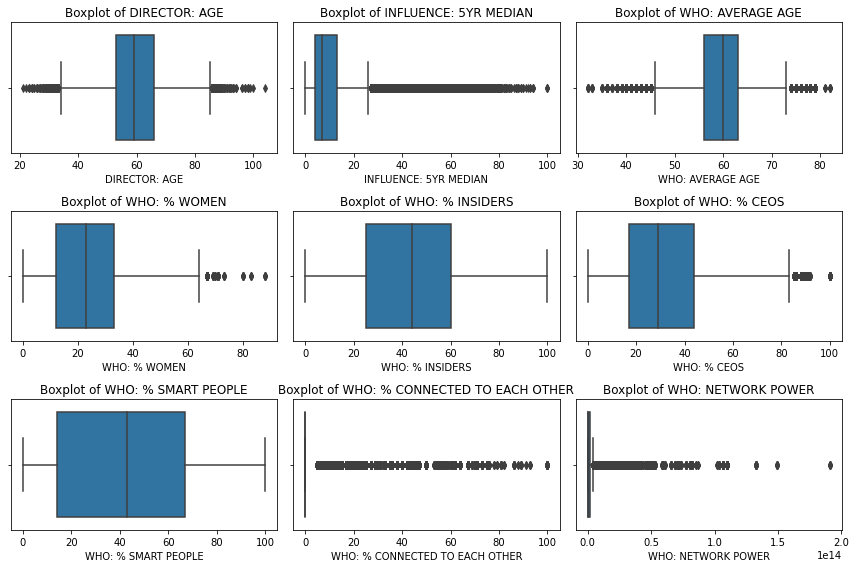

In [17]:
diversity_cols = ['DIRECTOR: AGE','INFLUENCE: 5YR MEDIAN','WHO: AVERAGE AGE', 'WHO: % WOMEN',
       'WHO: % INSIDERS', 'WHO: % CEOS', 'WHO: % SMART PEOPLE',
       'WHO: % CONNECTED TO EACH OTHER', 'WHO: NETWORK POWER']

fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(diversity_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    

plt.tight_layout()
plt.show()

### Assess the distribution of the target variable to ensure a balanced dataset

/Users/tj/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PERFORMANCE: CATEGORY', ylabel='count'>

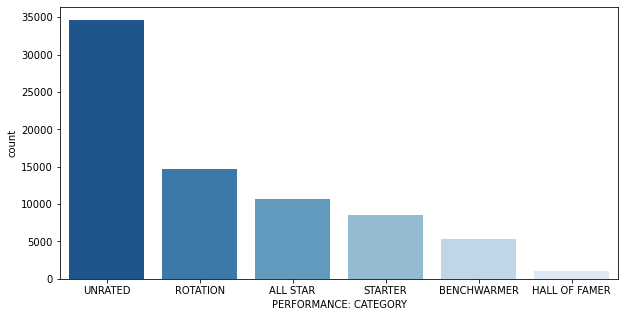

In [18]:
# Compute the order of categories based on their counts (descending)
category_order = df['PERFORMANCE: CATEGORY'].value_counts().index

plt.figure(figsize = (10,5))
sns.countplot(df['PERFORMANCE: CATEGORY'], palette = "Blues_r", order = category_order)

/Users/tj/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


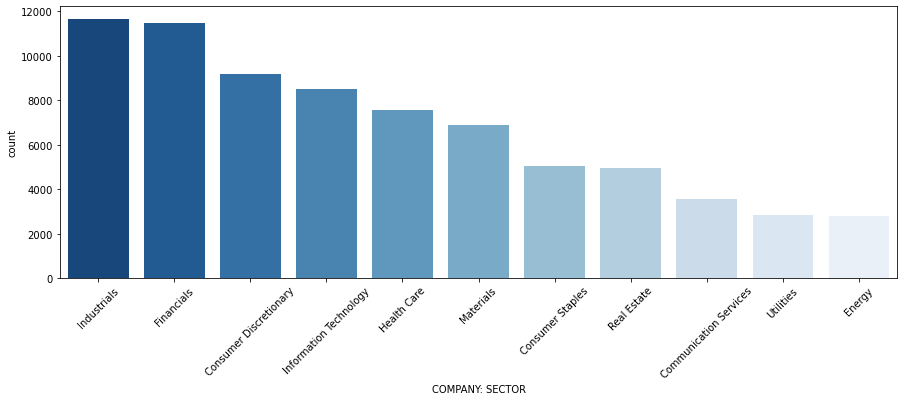

In [19]:
# Compute the order of categories based on their counts (descending)
sector_order = df['COMPANY: SECTOR'].value_counts().index

plt.figure(figsize = (15,5))
sns.countplot(df['COMPANY: SECTOR'], palette = "Blues_r", order = sector_order)
plt.xticks(rotation=45)

# Display the plot
plt.show()

/Users/tj/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DIRECTOR: GENDER', ylabel='count'>

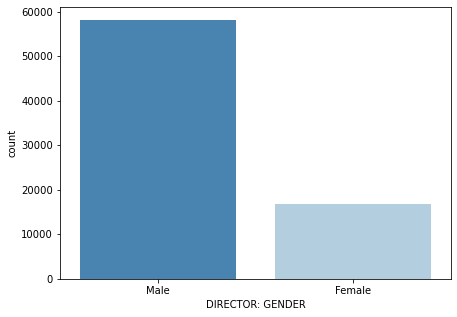

In [20]:
# Compute the order of categories based on their counts (descending)
gender_order = df['DIRECTOR: GENDER'].value_counts().index

plt.figure(figsize = (7,5))
sns.countplot(df['DIRECTOR: GENDER'], palette = "Blues_r", order = gender_order)

### Proportion of performance across different company sector

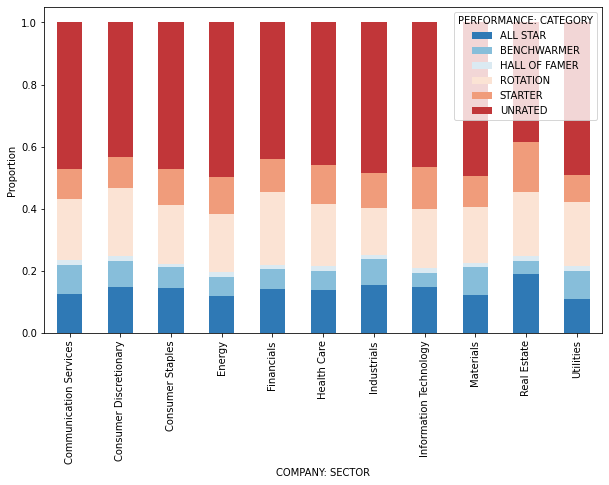

In [21]:
# Calculate the frequency of each PERFORMANCE: CATEGORY for each DIRECTOR: GENDER category
grouped_data = df.groupby(['COMPANY: SECTOR', 'PERFORMANCE: CATEGORY']).size().unstack()

# Normalize the data to show proportions instead of counts
grouped_data_normalized = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Define a color palette using seaborn
palette = sns.color_palette("RdBu_r", n_colors=6)

# Create the stacked bar chart
ax = grouped_data_normalized.plot(kind='bar', stacked=True, figsize=(10, 6), color=palette)
ax.set_ylabel('Proportion')
plt.show()

### Feature Engineering

To ensure the robustness and accuracy of our model, we are eliminating rows that contain 'unrated' performance, as these could potentially introduce noise or skewness into our predictive analysis

In [22]:
df = df[df['PERFORMANCE: CONTROVERSY WIN RATE'] != 'Unrated']
df = df[df['PERFORMANCE: CARBON INTENSITY WIN RATE'] != 'Unrated']

Eliminate unused features

In [23]:
df.drop(['DIRECTOR: ID','DIRECTOR: NAME','DIRECTOR: DIVERSITY','COMPANY: NAME','COMPANY: TICKER',
         'COMPANY: CUSIP','INFLUENCE:2022','INFLUENCE:2021','INFLUENCE:2020','INFLUENCE:2019',
         'INFLUENCE:2018','INFLUENCE: HIGHEST INFLUENCE AT…','PERFORMANCE: WIN RATE','PERFORMANCE: EBITDA WIN RATE','PERFORMANCE: TSR WIN RATE','PERFORMANCE: CONTROVERSY WIN RATE','PERFORMANCE: CARBON INTENSITY WIN RATE'],axis = 1, inplace = True)

Replace the null values for 'DIRECTOR: AGE' with mean since the distribution is central tendency

In [24]:
age_mean = df['DIRECTOR: AGE'].mean()
df['DIRECTOR: AGE'].fillna(age_mean, inplace= True)

Replace the null values for 'INFLUENCE: 5YR MEDIAN' feature with median since the distribution is skewed

In [25]:
inf5_median = df['INFLUENCE: 5YR MEDIAN'].median()
df['INFLUENCE: 5YR MEDIAN'].fillna(inf5_median, inplace= True)

Replace the null values for categorical variables with mode

In [26]:
sector_mode = df['COMPANY: SECTOR'].mode()
df['COMPANY: SECTOR'].fillna(sector_mode[0], inplace= True)

In [27]:
gender_mode = df['DIRECTOR: GENDER'].mode()
df['DIRECTOR: GENDER'].fillna(gender_mode[0], inplace= True)

Handle the outlier

In [28]:
Q1 = df['RESUME: NETWORK POWER'].quantile(0.25)
Q3 = df['RESUME: NETWORK POWER'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['RESUME: NETWORK POWER'] >= lower_bound) & (df['RESUME: NETWORK POWER'] <= upper_bound)]

### Encoding the categorical variables

In [29]:
df['DIRECTOR: GENDER'].value_counts()

Male      23545
Female     5451
Name: DIRECTOR: GENDER, dtype: int64

1 = Male, 0 = Female

In [30]:
encoder = LabelEncoder()
df['DIRECTOR: GENDER'] = encoder.fit_transform(df['DIRECTOR: GENDER'])

1 = Yes, 0 = No

In [31]:
columns_to_encode = ['INFLUENCE DRIVER: ADVANCED DEGREE', 'INFLUENCE DRIVER: ELITE SCHOOL', 'INFLUENCE DRIVER: HAS BEEN CEO','INFLUENCE DRIVER: FOUNDER-CEO-FAMILY','INFLUENCE DRIVER: CHAIR ROLE','INFLUENCE DRIVER: COMMITTEE ROLE','INFLUENCE DRIVER: BOARD CONNECTIONS','INFLUENCE DRIVER: STRUCTURAL ADVANTAGE','RESUME: SMARTS',
       'RESUME: EXPERIENCE']

for col in columns_to_encode:
    df[col] = df[col].replace({"Yes": 1, "No": 0})

In [32]:
df['PERFORMANCE: CATEGORY'].value_counts()

ROTATION         10320
ALL STAR          8016
STARTER           6361
BENCHWARMER       3357
HALL OF FAMER      472
UNRATED            470
Name: PERFORMANCE: CATEGORY, dtype: int64

"HALL OF FAMER": 5, "ALL STAR": 4, "STARTER": 3, "ROTATION": 2, "BENCHWARMER": 1, "UNRATED": 0

In [33]:
category_to_value = {
    "HALL OF FAMER": 2,
    "ALL STAR": 2,
    "STARTER": 1,
    "ROTATION": 1,
    "BENCHWARMER": 0,
    "UNRATED": 0
}

# Encode the values in the 'PERFORMANCE: CATEGORY' column
df['PERFORMANCE: CATEGORY'] = df['PERFORMANCE: CATEGORY'].map(category_to_value)

In [122]:
columns_to_select = [col for col in df.columns if col not in ['COMPANY: DOMICILE', 'COMPANY: SECTOR']]

# Select all rows and specific columns using DataFrame.loc[]
filtered_df = df.loc[:, columns_to_select]

### Correlation Matrix

In [35]:
filtered_df = filtered_df.dropna(axis = 0)

In [36]:
corr = filtered_df.corr()

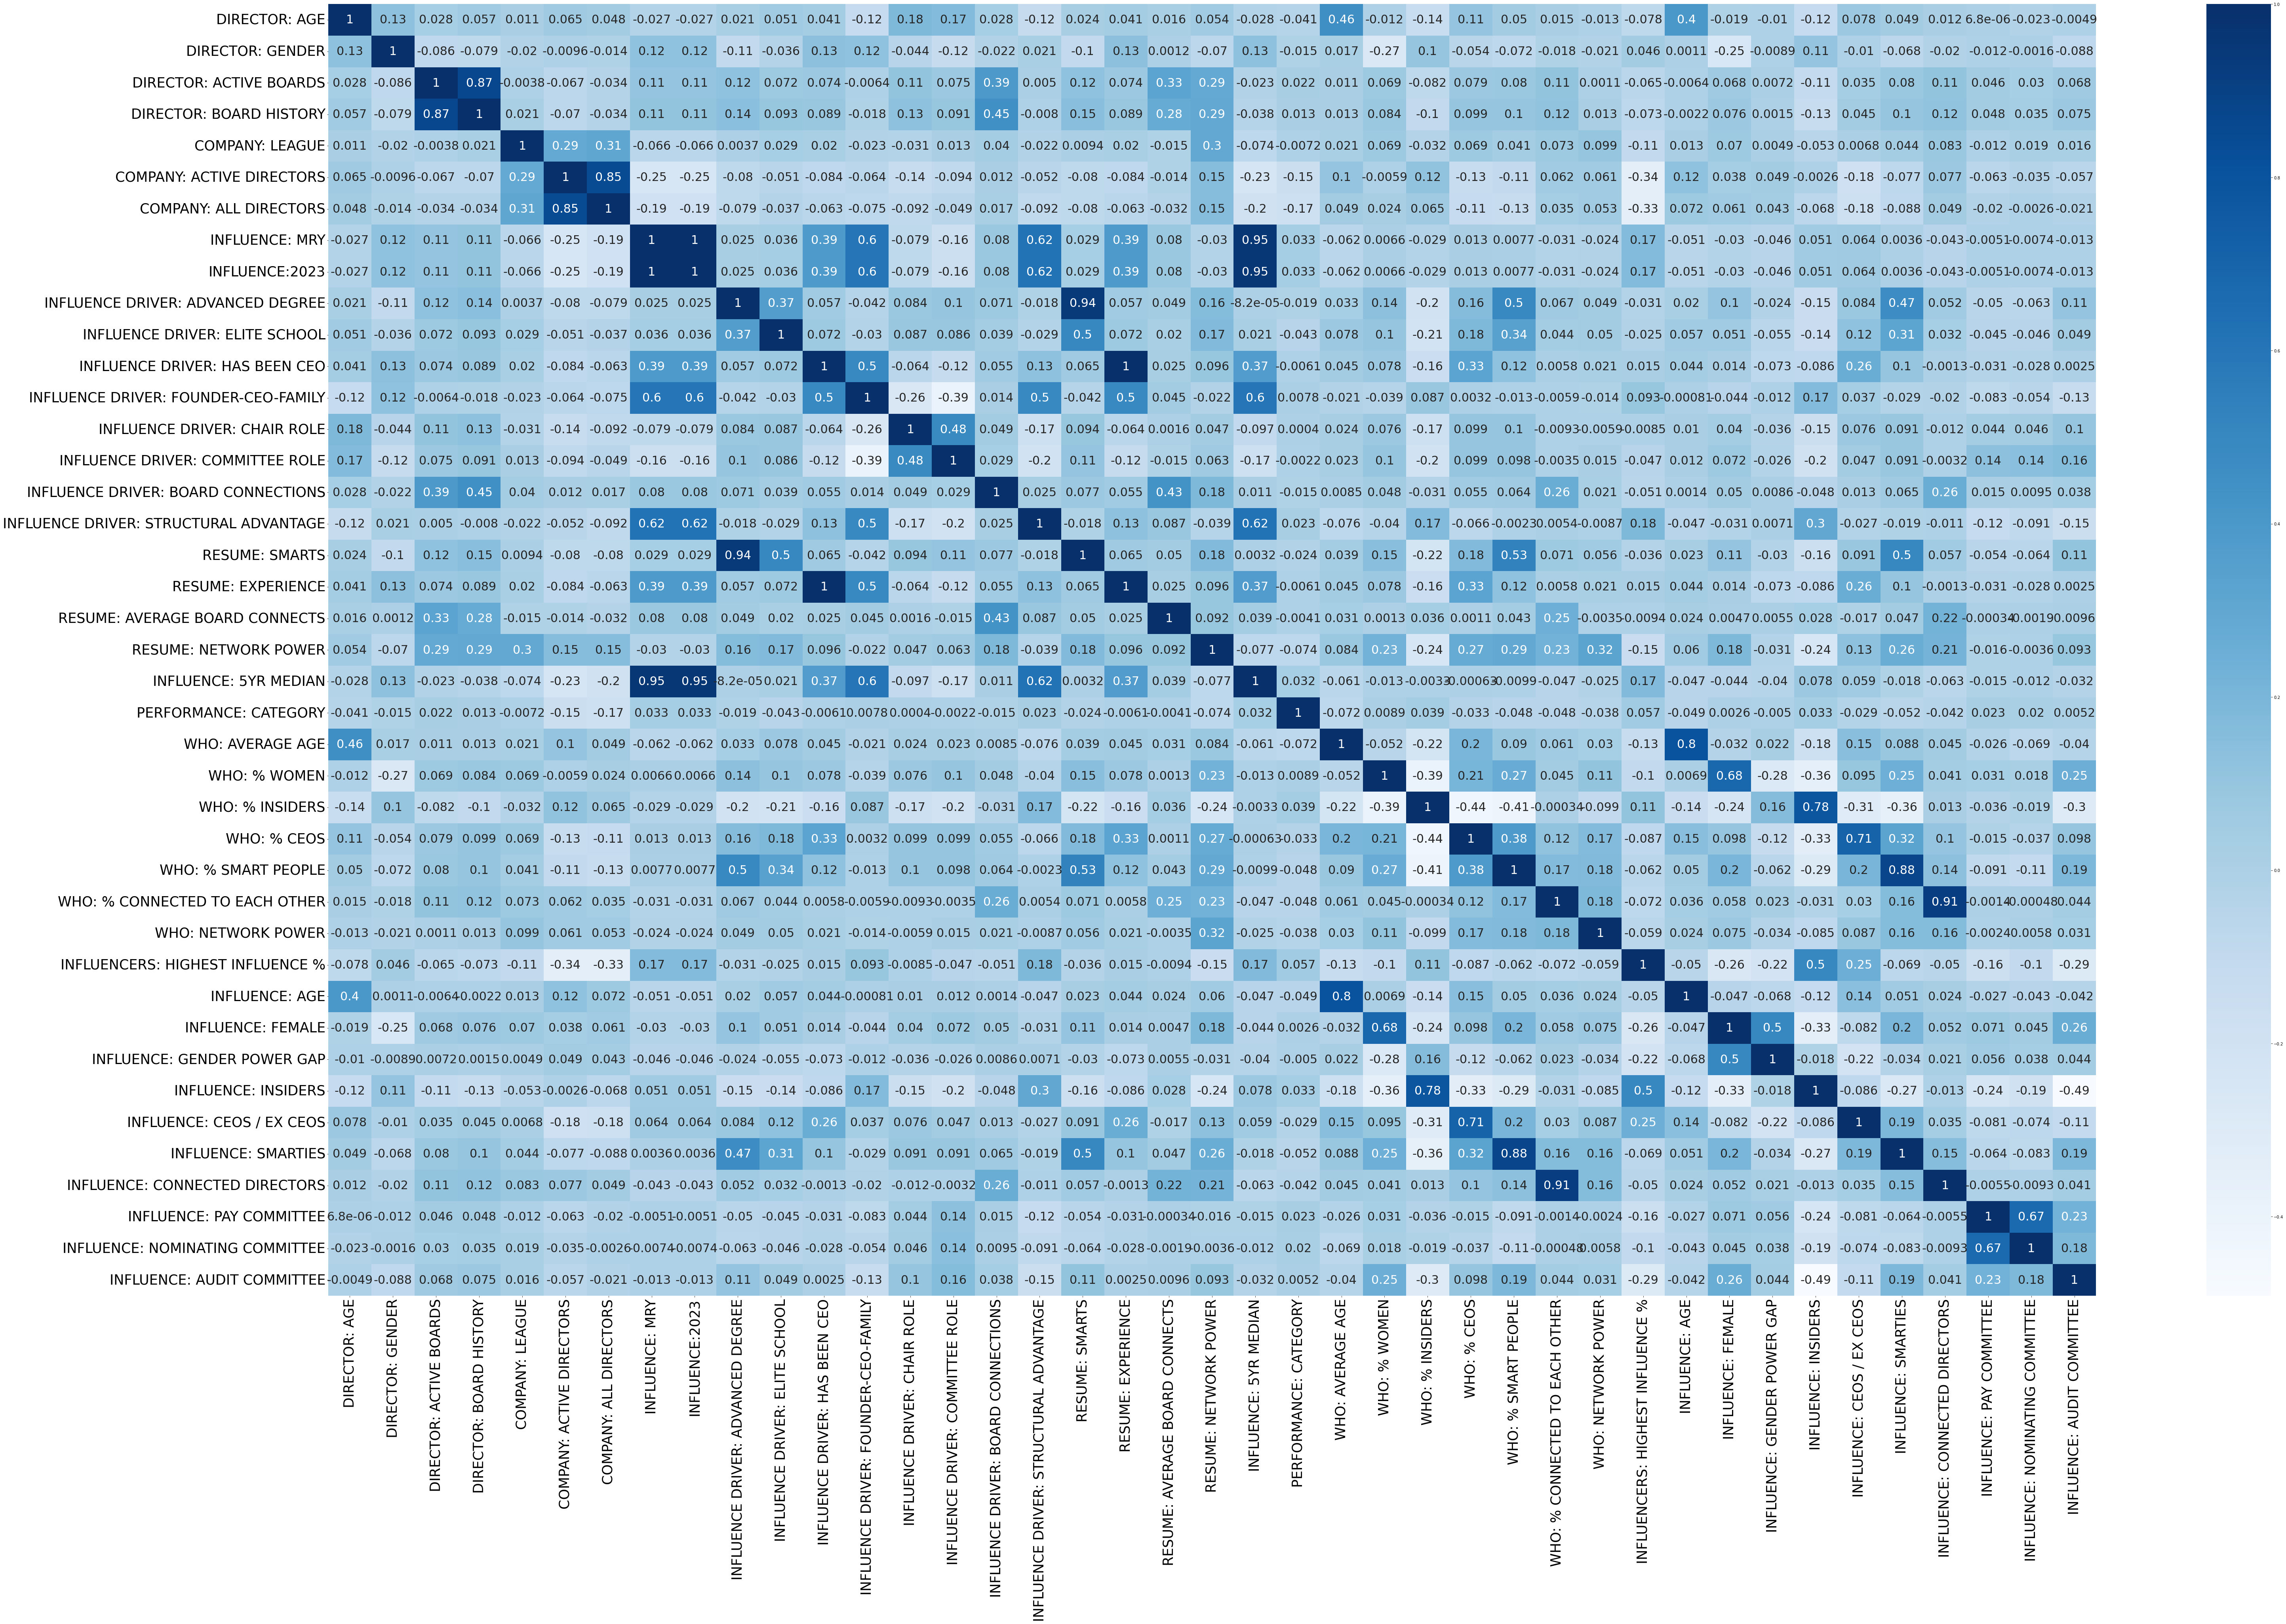

In [37]:
plt.figure(figsize=(100, 60))
sns.heatmap(corr, cmap = 'Blues', annot=True,annot_kws={"size": 30})
# Change the size of the x-axis labels
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)

plt.show()

### Determine the multicollinearity using VIF

In [38]:
filtered_df = filtered_df.drop('PERFORMANCE: CATEGORY', axis=1)
filtered_df = filtered_df.select_dtypes(include=np.number)

In [39]:
vif_data = pd.DataFrame()
vif_data['Feature'] = filtered_df.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(filtered_df.values, i) for i in range(len(filtered_df.columns))]

# Print the VIF values
print(vif_data)

                                   Feature          VIF
0                            DIRECTOR: AGE         1.40
1                         DIRECTOR: GENDER         1.16
2                  DIRECTOR: ACTIVE BOARDS         4.22
3                  DIRECTOR: BOARD HISTORY         4.77
4                          COMPANY: LEAGUE         1.20
5                COMPANY: ACTIVE DIRECTORS         4.17
6                   COMPANY: ALL DIRECTORS         3.85
7                           INFLUENCE: MRY 593196876.80
8                           INFLUENCE:2023 593196876.80
9        INFLUENCE DRIVER: ADVANCED DEGREE         9.44
10          INFLUENCE DRIVER: ELITE SCHOOL         1.58
11          INFLUENCE DRIVER: HAS BEEN CEO   1084049.46
12    INFLUENCE DRIVER: FOUNDER-CEO-FAMILY         2.36
13            INFLUENCE DRIVER: CHAIR ROLE         1.38
14        INFLUENCE DRIVER: COMMITTEE ROLE         1.54
15     INFLUENCE DRIVER: BOARD CONNECTIONS         1.51
16  INFLUENCE DRIVER: STRUCTURAL ADVANTAGE      

### Eliminate the features that has high multicollinearity

In [40]:
df = df.drop(['INFLUENCE: MRY'], axis = 1)

### Perform one-hot encoding on the COMPANY: DOMICILE and COMPANY: SECTOR

In [41]:
df = pd.get_dummies(df, columns=['COMPANY: DOMICILE','COMPANY: SECTOR','INFLUENCERS: BOARD TYPE'])

# Predictive Analysis

### Perform the Decision Tree classification

In [42]:
X = df.drop(['PERFORMANCE: CATEGORY'], axis = 1)
y = df['PERFORMANCE: CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
#define classification algorithm
clf_tree = tree.DecisionTreeClassifier(max_depth = 4)

# get start time
start_time = time.time()

# fit the model
clf_tree = clf_tree.fit(X_train, y_train)

# calculate and print the time taken to train the model
train_time = time.time() - start_time
print("Training time: ", train_time)

# reset start time
start_time = time.time()

# make predictions
y_pred_tree = clf_tree.predict(X_test)

# calculate and print the time taken to make predictions
predict_time = time.time() - start_time
print("Prediction time: ", predict_time)

Training time:  0.08957719802856445
Prediction time:  0.003998994827270508


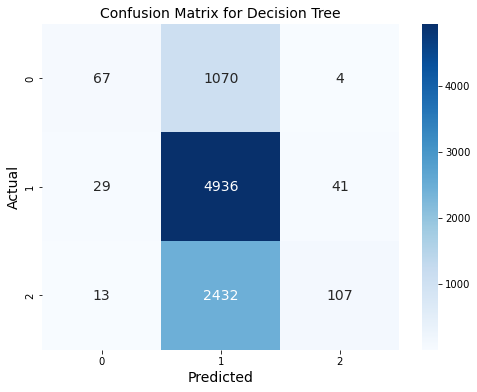

In [44]:
cm_tree = confusion_matrix(y_test, y_pred_tree)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues',annot_kws={"size": 14})

plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.title('Confusion Matrix for Decision Tree', fontsize = 14)

# Show the plot
plt.show()

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.61      0.06      0.11      1141
           1       0.58      0.99      0.73      5006
           2       0.70      0.04      0.08      2552

    accuracy                           0.59      8699
   macro avg       0.63      0.36      0.31      8699
weighted avg       0.62      0.59      0.46      8699



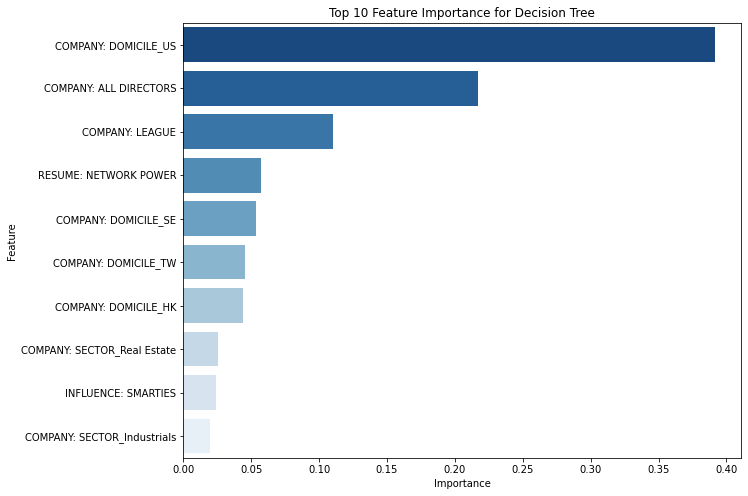

In [46]:
# Extract feature importances
importances = clf_tree.feature_importances_

# Create a DataFrame with feature names and their corresponding importances
features_importance = pd.DataFrame({
    "Feature": X.columns, 
    "Importance": importances
})

# Sort the DataFrame by importance in descending order
features_importance = features_importance.sort_values("Importance", ascending=False)

# Select the top 10 most important features
top_10_features = features_importance.head(10)

# Plot the feature importances of the top 10 features
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=top_10_features, palette = 'Blues_r')
plt.title('Top 10 Feature Importance for Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Perform the Random Forest classification

In [47]:
X = df.drop('PERFORMANCE: CATEGORY', axis = 1)
y = df['PERFORMANCE: CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
# create regressor object
clf_rdm = RandomForestClassifier(n_estimators = 100, random_state = 42)

# get start time
start_time = time.time()

# fit the regressor with x and y data
clf_rdm = clf_rdm.fit(X_train, y_train)  

# calculate and print the time taken to train the model
train_time = time.time() - start_time
print("Training time: ", train_time)

# reset start time
start_time = time.time()

# make predictions
y_pred_rdm = clf_rdm.predict(X_test)

# calculate and print the time taken to make predictions
predict_time = time.time() - start_time
print("Prediction time: ", predict_time)

Training time:  2.734609842300415
Prediction time:  0.13966012001037598


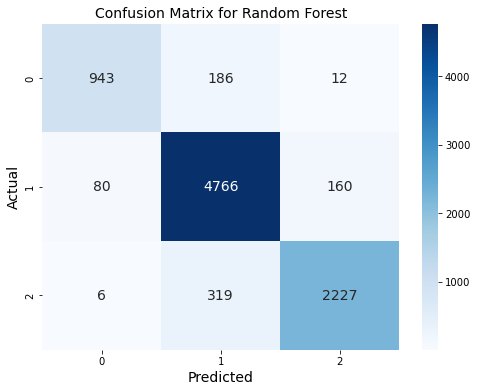

In [49]:
cm_rdm = confusion_matrix(y_test, y_pred_rdm)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rdm, annot=True, fmt='d', cmap='Blues',annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.title('Confusion Matrix for Random Forest', fontsize = 14)

# Show the plot
plt.show()

In [50]:
cm_rdm

array([[ 943,  186,   12],
       [  80, 4766,  160],
       [   6,  319, 2227]])

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rdm))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1141
           1       0.90      0.95      0.93      5006
           2       0.93      0.87      0.90      2552

    accuracy                           0.91      8699
   macro avg       0.92      0.88      0.90      8699
weighted avg       0.91      0.91      0.91      8699



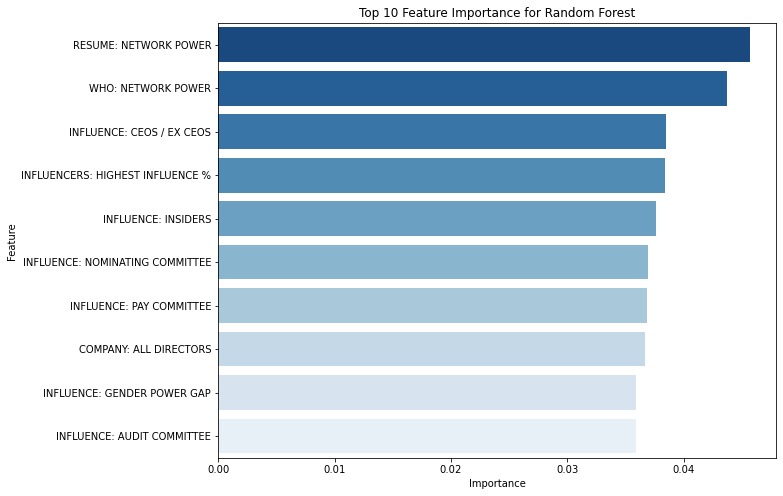

In [130]:
# Extract feature importances
importances = clf_rdm.feature_importances_

# Create a DataFrame with feature names and their corresponding importances
features_importance = pd.DataFrame({
    "Feature": X.columns, 
    "Importance": importances
})

# Sort the DataFrame by importance in descending order
features_importance = features_importance.sort_values("Importance", ascending=False)

# Select the top 10 most important features
top_10_features = features_importance.head(10)

# Plot the feature importances of the top 10 features
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=top_10_features, palette='Blues_r')
plt.title('Top 10 Feature Importance for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Perform the XGBoost classification

In [53]:
X = df.drop('PERFORMANCE: CATEGORY', axis = 1)
y = df['PERFORMANCE: CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(objective = 'multi:softmax', 
                        eval_metric = 'merror',
                        learning_rate = 0.1, 
                        max_depth = 5, 
                        n_estimators = 1000, 
                        verbosity = 1,
                        seed = 42)
# get start time
start_time = time.time()

# fit the model
clf_xgb.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_set = [(X_test, y_test)])

# calculate and print the time taken to train the model
train_time = time.time() - start_time

# reset start time
start_time = time.time()

[0]	validation_0-merror:0.40028


/Users/tj/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-merror:0.39671
[2]	validation_0-merror:0.39384
[3]	validation_0-merror:0.38936
[4]	validation_0-merror:0.38970
[5]	validation_0-merror:0.38372
[6]	validation_0-merror:0.38648
[7]	validation_0-merror:0.38591
[8]	validation_0-merror:0.38418
[9]	validation_0-merror:0.38338
[10]	validation_0-merror:0.38223
[11]	validation_0-merror:0.37763
[12]	validation_0-merror:0.37717
[13]	validation_0-merror:0.37533
[14]	validation_0-merror:0.37280
[15]	validation_0-merror:0.37211
[16]	validation_0-merror:0.37039
[17]	validation_0-merror:0.36958
[18]	validation_0-merror:0.36901
[19]	validation_0-merror:0.36682
[20]	validation_0-merror:0.36556
[21]	validation_0-merror:0.36475
[22]	validation_0-merror:0.36338
[23]	validation_0-merror:0.36292
[24]	validation_0-merror:0.36246
[25]	validation_0-merror:0.36326
[26]	validation_0-merror:0.36200
[27]	validation_0-merror:0.36027
[28]	validation_0-merror:0.35958
[29]	validation_0-merror:0.35970
[30]	validation_0-merror:0.35740
[31]	validation_0-m

[246]	validation_0-merror:0.22083
[247]	validation_0-merror:0.22072
[248]	validation_0-merror:0.21991
[249]	validation_0-merror:0.21911
[250]	validation_0-merror:0.21922
[251]	validation_0-merror:0.21830
[252]	validation_0-merror:0.21773
[253]	validation_0-merror:0.21796
[254]	validation_0-merror:0.21750
[255]	validation_0-merror:0.21692
[256]	validation_0-merror:0.21623
[257]	validation_0-merror:0.21623
[258]	validation_0-merror:0.21612
[259]	validation_0-merror:0.21600
[260]	validation_0-merror:0.21600
[261]	validation_0-merror:0.21589
[262]	validation_0-merror:0.21566
[263]	validation_0-merror:0.21497
[264]	validation_0-merror:0.21497
[265]	validation_0-merror:0.21451
[266]	validation_0-merror:0.21370
[267]	validation_0-merror:0.21278
[268]	validation_0-merror:0.21290
[269]	validation_0-merror:0.21244
[270]	validation_0-merror:0.21209
[271]	validation_0-merror:0.21083
[272]	validation_0-merror:0.21140
[273]	validation_0-merror:0.21152
[274]	validation_0-merror:0.21094
[275]	validati

[487]	validation_0-merror:0.14887
[488]	validation_0-merror:0.14921
[489]	validation_0-merror:0.14898
[490]	validation_0-merror:0.14852
[491]	validation_0-merror:0.14841
[492]	validation_0-merror:0.14898
[493]	validation_0-merror:0.14852
[494]	validation_0-merror:0.14818
[495]	validation_0-merror:0.14783
[496]	validation_0-merror:0.14783
[497]	validation_0-merror:0.14726
[498]	validation_0-merror:0.14680
[499]	validation_0-merror:0.14668
[500]	validation_0-merror:0.14680
[501]	validation_0-merror:0.14634
[502]	validation_0-merror:0.14703
[503]	validation_0-merror:0.14680
[504]	validation_0-merror:0.14634
[505]	validation_0-merror:0.14714
[506]	validation_0-merror:0.14749
[507]	validation_0-merror:0.14645
[508]	validation_0-merror:0.14611
[509]	validation_0-merror:0.14622
[510]	validation_0-merror:0.14622
[511]	validation_0-merror:0.14634
[512]	validation_0-merror:0.14622
[513]	validation_0-merror:0.14657
[514]	validation_0-merror:0.14622
[515]	validation_0-merror:0.14599
[516]	validati

In [55]:
print("Training time: ", train_time)

# Generate predictions
y_pred_xgb = clf_xgb.predict(X_test)

# calculate and print the time taken to make predictions
predict_time = time.time() - start_time
print("Prediction time: ", predict_time)

Training time:  45.79612898826599
Prediction time:  0.07284712791442871


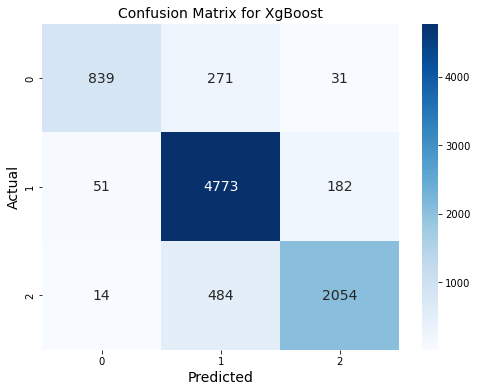

In [56]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual' , fontsize = 14)
plt.title('Confusion Matrix for XgBoost' , fontsize = 14)

# Show the plot
plt.show()

In [57]:
conf_matrix_xgb

array([[ 839,  271,   31],
       [  51, 4773,  182],
       [  14,  484, 2054]])

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82      1141
           1       0.86      0.95      0.91      5006
           2       0.91      0.80      0.85      2552

    accuracy                           0.88      8699
   macro avg       0.90      0.83      0.86      8699
weighted avg       0.88      0.88      0.88      8699



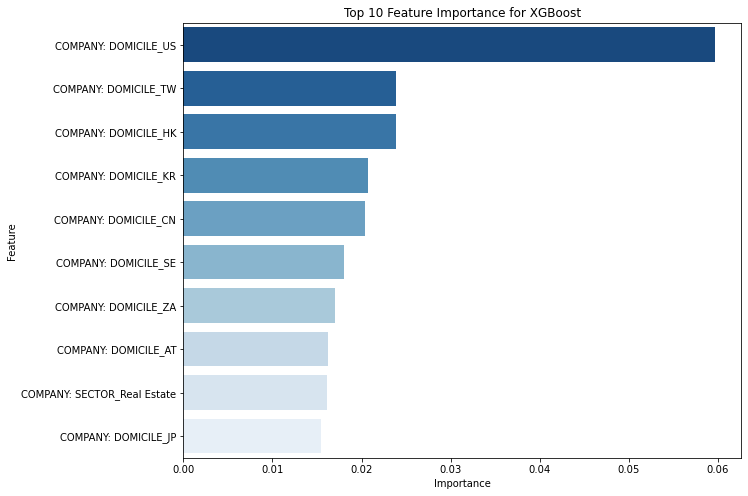

In [132]:
# Extract feature importances
importances = clf_xgb.feature_importances_

# Create a DataFrame with feature names and their corresponding importances
features_importance = pd.DataFrame({
    "Feature": X.columns, 
    "Importance": importances
})

# Sort the DataFrame by importance in descending order
features_importance = features_importance.sort_values("Importance", ascending=False)

# Select the top 10 most important features
top_10_features = features_importance.head(10)


# Plot the feature importances of the top 10 features
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=top_10_features, palette = 'Blues_r')
plt.title('Top 10 Feature Importance for XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Perform the Neural Network model

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
# Define a function to create your Keras model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [76]:
# Set the learning rate
learning_rate = 0.001

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [77]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
635/635 [==============================] - 1s 1ms/step - loss: 0.9938 - accuracy: 0.5526 - val_loss: 0.9225 - val_accuracy: 0.5755
Epoch 2/100
635/635 [==============================] - 1s 1ms/step - loss: 0.9291 - accuracy: 0.5775 - val_loss: 0.9018 - val_accuracy: 0.5759
Epoch 3/100
635/635 [==============================] - 1s 1ms/step - loss: 0.9124 - accuracy: 0.5834 - val_loss: 0.8808 - val_accuracy: 0.5868
Epoch 4/100
635/635 [==============================] - 1s 1ms/step - loss: 0.8964 - accuracy: 0.5895 - val_loss: 0.8740 - val_accuracy: 0.5834
Epoch 5/100
635/635 [==============================] - 1s 1ms/step - loss: 0.8815 - accuracy: 0.5898 - val_loss: 0.8554 - val_accuracy: 0.5946
Epoch 6/100
635/635 [==============================] - 1s 1ms/step - loss: 0.8713 - accuracy: 0.5967 - val_loss: 0.8463 - val_accuracy: 0.6001
Epoch 7/100
635/635 [==============================] - 1s 1ms/step - loss: 0.8570 - accuracy: 0.5974 - val_loss: 0.8244 - val_accuracy: 0.6023

Epoch 58/100
635/635 [==============================] - 1s 1ms/step - loss: 0.4626 - accuracy: 0.8105 - val_loss: 0.6975 - val_accuracy: 0.7793
Epoch 59/100
635/635 [==============================] - 1s 1ms/step - loss: 0.4749 - accuracy: 0.8091 - val_loss: 0.6598 - val_accuracy: 0.7817
Epoch 60/100
635/635 [==============================] - 1s 1ms/step - loss: 0.4647 - accuracy: 0.8131 - val_loss: 0.7018 - val_accuracy: 0.7864
Epoch 61/100
635/635 [==============================] - 1s 1ms/step - loss: 0.4643 - accuracy: 0.8098 - val_loss: 0.6883 - val_accuracy: 0.7891
Epoch 62/100
635/635 [==============================] - 1s 1ms/step - loss: 0.4717 - accuracy: 0.8096 - val_loss: 0.6438 - val_accuracy: 0.7928
Epoch 63/100
635/635 [==============================] - 1s 1ms/step - loss: 0.4623 - accuracy: 0.8124 - val_loss: 0.7314 - val_accuracy: 0.7879
Epoch 64/100
635/635 [==============================] - 1s 1ms/step - loss: 0.4515 - accuracy: 0.8112 - val_loss: 0.6807 - val_accuracy:

In [84]:
# Obtain the predicted probabilities from the neural network
y_pred_probs1 = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_nn1 = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm_nn1 = confusion_matrix(y_test, y_pred_nn)

272/272 [==============================] - 0s 473us/step


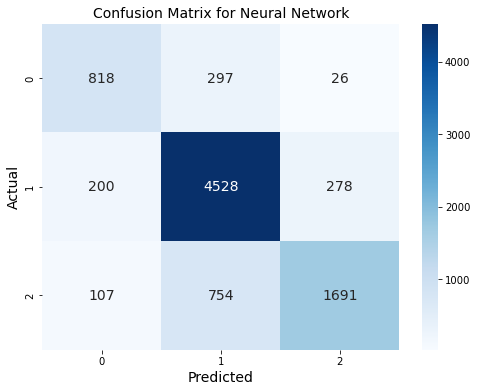

In [85]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn1, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual' , fontsize = 14)
plt.title('Confusion Matrix for Neural Network' , fontsize = 14)

# Show the plot
plt.show()

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nn1))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1141
           1       0.81      0.90      0.86      5006
           2       0.85      0.66      0.74      2552

    accuracy                           0.81      8699
   macro avg       0.80      0.76      0.77      8699
weighted avg       0.81      0.81      0.81      8699



### Optimizing the Model by Hyperparametric Tuning

In [139]:
from keras_tuner import RandomSearch

# Define a function to create your Keras model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input',
                                 min_value=128,
                                 max_value=256,
                                 step=32),
                    activation='relu', 
                    input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_hidden',
                                 min_value=32,
                                 max_value=128,
                                 step=32), 
                    activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_hidden',
                                 min_value=32,
                                 max_value=128,
                                 step=32), 
                    activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

start_time = time.time()

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # the number of different models to try
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Obtain the predicted probabilities from the neural network
y_pred_probs2 = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred_nn2 = np.argmax(y_pred_probs2, axis=1)

# Compute the confusion matrix
cm_nn2 = confusion_matrix(y_test, y_pred_nn2)

end_time = time.time()

computation_time = end_time - start_time

print(f"The computation time is {computation_time} seconds.")

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
635/635 [==============================] - 2s 1ms/step - loss: 0.9112 - accuracy: 0.5877 - val_loss: 0.8504 - val_accuracy: 0.6193
Epoch 2/100
635/635 [==============================] - 1s 1ms/step - loss: 0.8283 - accuracy: 0.6299 - val_loss: 0.7909 - val_accuracy: 0.6470
Epoch 3/100
635/635 [==============================] - 1s 1ms/step - loss: 0.7695 - accuracy: 0.6590 - val_loss: 0.7623 - val_accuracy: 0.6542
Epoch 4/100
635/635 [==============================] - 1s 1ms/step - loss: 0.7112 - accuracy: 0.6885 - val_loss: 0.7226 - val_accuracy: 0.6812
Epoch 5/100
635/635 [==============================] - 1s 1ms/step - loss: 0.6578 - accuracy: 0.7196 - val_loss: 0.7015 - val_accuracy: 0.7049
Epoch 6/100
635/635 [==============================] - 1s 1ms/step - loss: 0.5982 - accuracy: 0.7468 - val_loss: 0.6478 - val_accuracy: 0.7320
Epoch 7/100
635/635 [===============

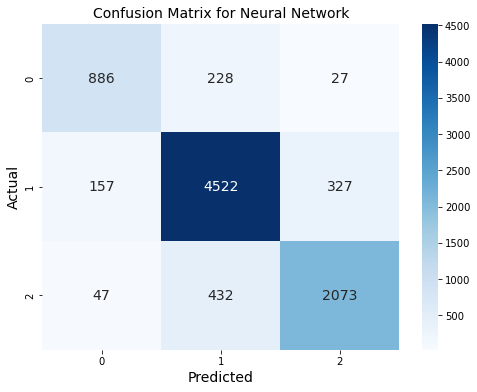

In [140]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn2, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual' , fontsize = 14)
plt.title('Confusion Matrix for Neural Network' , fontsize = 14)

# Show the plot
plt.show()

In [141]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nn2))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1141
           1       0.87      0.90      0.89      5006
           2       0.85      0.81      0.83      2552

    accuracy                           0.86      8699
   macro avg       0.85      0.83      0.84      8699
weighted avg       0.86      0.86      0.86      8699



### Perform the CatBoost Model

In [95]:
from catboost import CatBoostClassifier, Pool

catboost_train_data = Pool(X_train, y_train)
clf_cat = CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1,loss_function='MultiClass')
clf_cat.fit(catboost_train_data, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0642401	total: 67.7ms	remaining: 3.32s
1:	learn: 1.0375065	total: 70.9ms	remaining: 1.7s
2:	learn: 1.0163166	total: 73.7ms	remaining: 1.15s
3:	learn: 0.9992829	total: 76ms	remaining: 874ms
4:	learn: 0.9852150	total: 78.8ms	remaining: 710ms
5:	learn: 0.9733116	total: 81.4ms	remaining: 597ms
6:	learn: 0.9636257	total: 86.6ms	remaining: 532ms
7:	learn: 0.9530995	total: 89.9ms	remaining: 472ms
8:	learn: 0.9459469	total: 93.2ms	remaining: 425ms
9:	learn: 0.9406546	total: 96.7ms	remaining: 387ms
10:	learn: 0.9357072	total: 99.6ms	remaining: 353ms
11:	learn: 0.9310285	total: 102ms	remaining: 324ms
12:	learn: 0.9267434	total: 106ms	remaining: 301ms
13:	learn: 0.9226279	total: 109ms	remaining: 280ms
14:	learn: 0.9186587	total: 112ms	remaining: 262ms
15:	learn: 0.9160813	total: 115ms	remaining: 245ms
16:	learn: 0.9124475	total: 119ms	remaining: 231ms
17:	learn: 0.9100510	total: 122ms	remaining: 217ms
18:	learn: 0.9076633	total: 125ms	remaining: 204ms
19:	learn: 0.9056800	total: 128ms

In [96]:
# Generate predictions
y_pred_cat = clf_cat.predict(X_test)

# Calculate the confusion matrix
conf_matrix_cat = confusion_matrix(y_test, y_pred_cat)

[[  49 1084    8]
 [  23 4940   43]
 [   1 2419  132]]


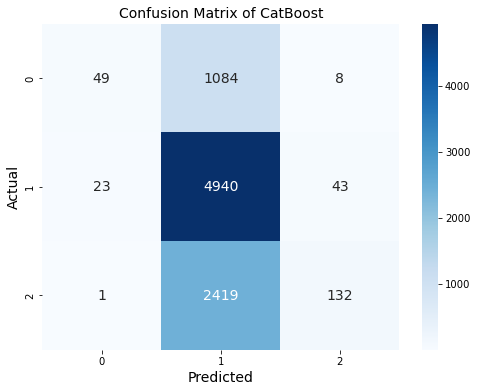

In [97]:
# Print the confusion matrix
print(conf_matrix_cat)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cat, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.title('Confusion Matrix of CatBoost', fontsize = 14)

# Show the plot
plt.show()

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.67      0.04      0.08      1141
           1       0.59      0.99      0.73      5006
           2       0.72      0.05      0.10      2552

    accuracy                           0.59      8699
   macro avg       0.66      0.36      0.30      8699
weighted avg       0.64      0.59      0.46      8699



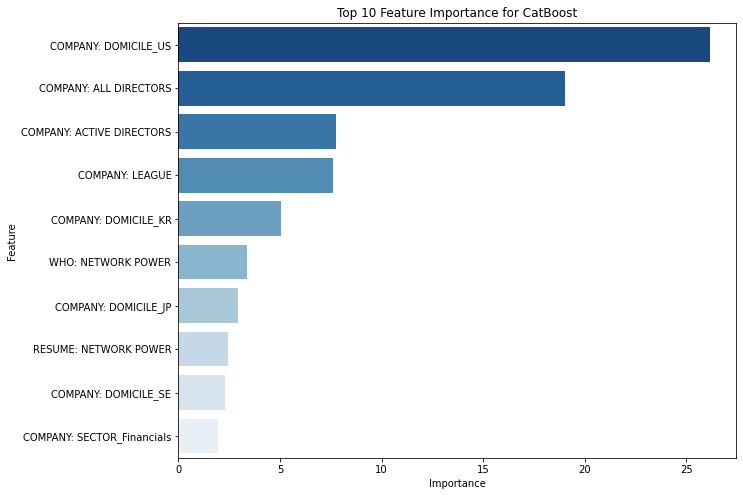

In [99]:
# Extract feature importances
importances = clf_cat.feature_importances_

# Create a DataFrame with feature names and their corresponding importances
features_importance = pd.DataFrame({
    "Feature": X.columns, 
    "Importance": importances
})

# Sort the DataFrame by importance in descending order
features_importance = features_importance.sort_values("Importance", ascending=False)

# Select the top 10 most important features
top_10_features = features_importance.head(10)


# Plot the feature importances of the top 10 features
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=top_10_features, palette = 'Blues_r')
plt.title('Top 10 Feature Importance for CatBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Perform Logistic Regression Model

In [100]:
# define logistic regression classifier
clf_logreg = LogisticRegression()

# get start time
start_time = time.time()

# fit the model
clf_logreg = clf_logreg.fit(X_train, y_train)

# calculate and print the time taken to train the model
train_time = time.time() - start_time
print("Training time: ", train_time)

# reset start time
start_time = time.time()

# make predictions
y_pred_logreg = clf_logreg.predict(X_test)

# calculate and print the time taken to make predictions
predict_time = time.time() - start_time
print("Prediction time: ", predict_time)

Training time:  0.5904891490936279
Prediction time:  0.0032508373260498047


/Users/tj/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
# Generate predictions
y_pred_logreg = clf_logreg.predict(X_test)

# Calculate the confusion matrix
conf_matrix_log = confusion_matrix(y_test, y_pred_logreg)

[[ 189  809  143]
 [ 133 4388  485]
 [  61 1748  743]]


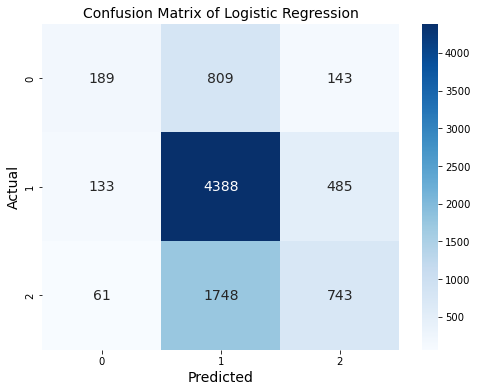

In [102]:
# Print the confusion matrix
print(conf_matrix_log)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.title('Confusion Matrix of Logistic Regression', fontsize = 14)

# Show the plot
plt.show()

In [103]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.49      0.17      0.25      1141
           1       0.63      0.88      0.73      5006
           2       0.54      0.29      0.38      2552

    accuracy                           0.61      8699
   macro avg       0.56      0.44      0.45      8699
weighted avg       0.59      0.61      0.57      8699



In [ ]:
coefficients = clf_logreg.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
features_importance = pd.DataFrame({
    "Feature": X.columns, 
    "Coefficient": coefficients
})

# Sort the DataFrame by coefficient magnitude in descending order
features_importance["abs_coefficient"] = features_importance.Coefficient.abs()
features_importance = features_importance.sort_values("abs_coefficient", ascending=False)

# Select the top 10 features with largest coefficients
top_10_features = features_importance.head(10)

# Plot the feature importances of the top 10 features
plt.figure(figsize=(10, 8))
sns.barplot(x="abs_coefficient", y="Feature", data=top_10_features, palette = 'Blues_r')
plt.title('Top 10 Feature Importance for Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

### Perform the Ensemble Model (Random Forest & XgBoost)

In [142]:
# Create the sub models
estimators = []

# Assuming that you have trained your models and named them as clf_rf (Random Forest), clf_xgb (XGBoost), clf_nn (Neural Network)
estimators.append(('RandomForest', clf_rdm))
estimators.append(('XGBoost', clf_xgb))

# Create the Stacking Classifier using a logistic regression as a final estimator
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# get start time
start_time = time.time()

# Fit the model
stack.fit(X_train, y_train)

# calculate and print the time taken to train the model
train_time = time.time() - start_time
print("Training time: ", train_time)

# reset start time
start_time = time.time()

# Make predictions
y_pred_esb = stack.predict(X_test)

# calculate and print the time taken to make predictions
predict_time = time.time() - start_time
print("Prediction time: ", predict_time)

Training time:  1209.43141579628
Prediction time:  0.25818610191345215


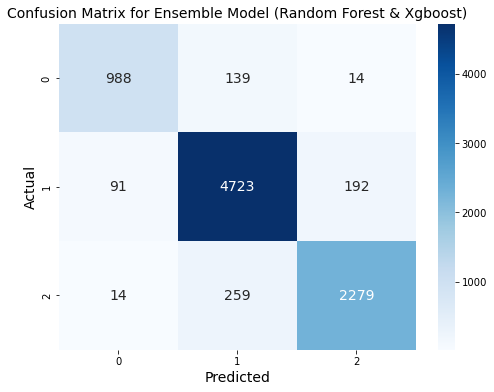

In [91]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix_esb = confusion_matrix(y_test, y_pred_esb)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_esb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual' , fontsize = 14)
plt.title('Confusion Matrix for Ensemble Model (Random Forest & Xgboost)' , fontsize = 14)

# Show the plot
plt.show()

In [128]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_esb))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1141
           1       0.92      0.94      0.93      5006
           2       0.92      0.89      0.90      2552

    accuracy                           0.92      8699
   macro avg       0.91      0.90      0.91      8699
weighted avg       0.92      0.92      0.92      8699



In [149]:
num_unique_companies = len(data['COMPANY: NAME'].unique())
print('Number of unique companies:', num_unique_companies)

Number of unique companies: 9131


In [150]:
data['COMPANY: DOMICILE'].value_counts()

US    19769
JP    10444
CN     8236
IN     2793
KR     2753
      ...  
GI        8
GE        8
CR        7
FO        7
BS        6
Name: COMPANY: DOMICILE, Length: 67, dtype: int64